#Main

Ingrese el nvt period 365
Ingrese el periodo de rebalanceo30


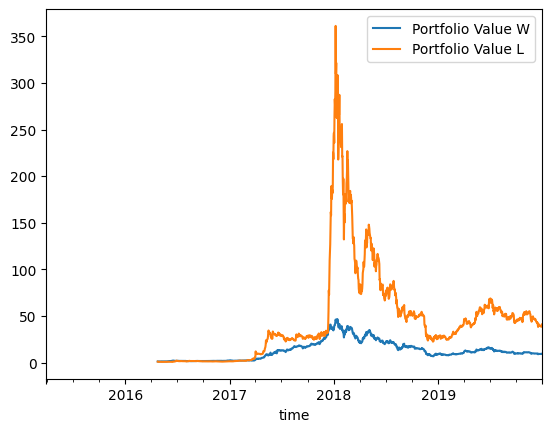

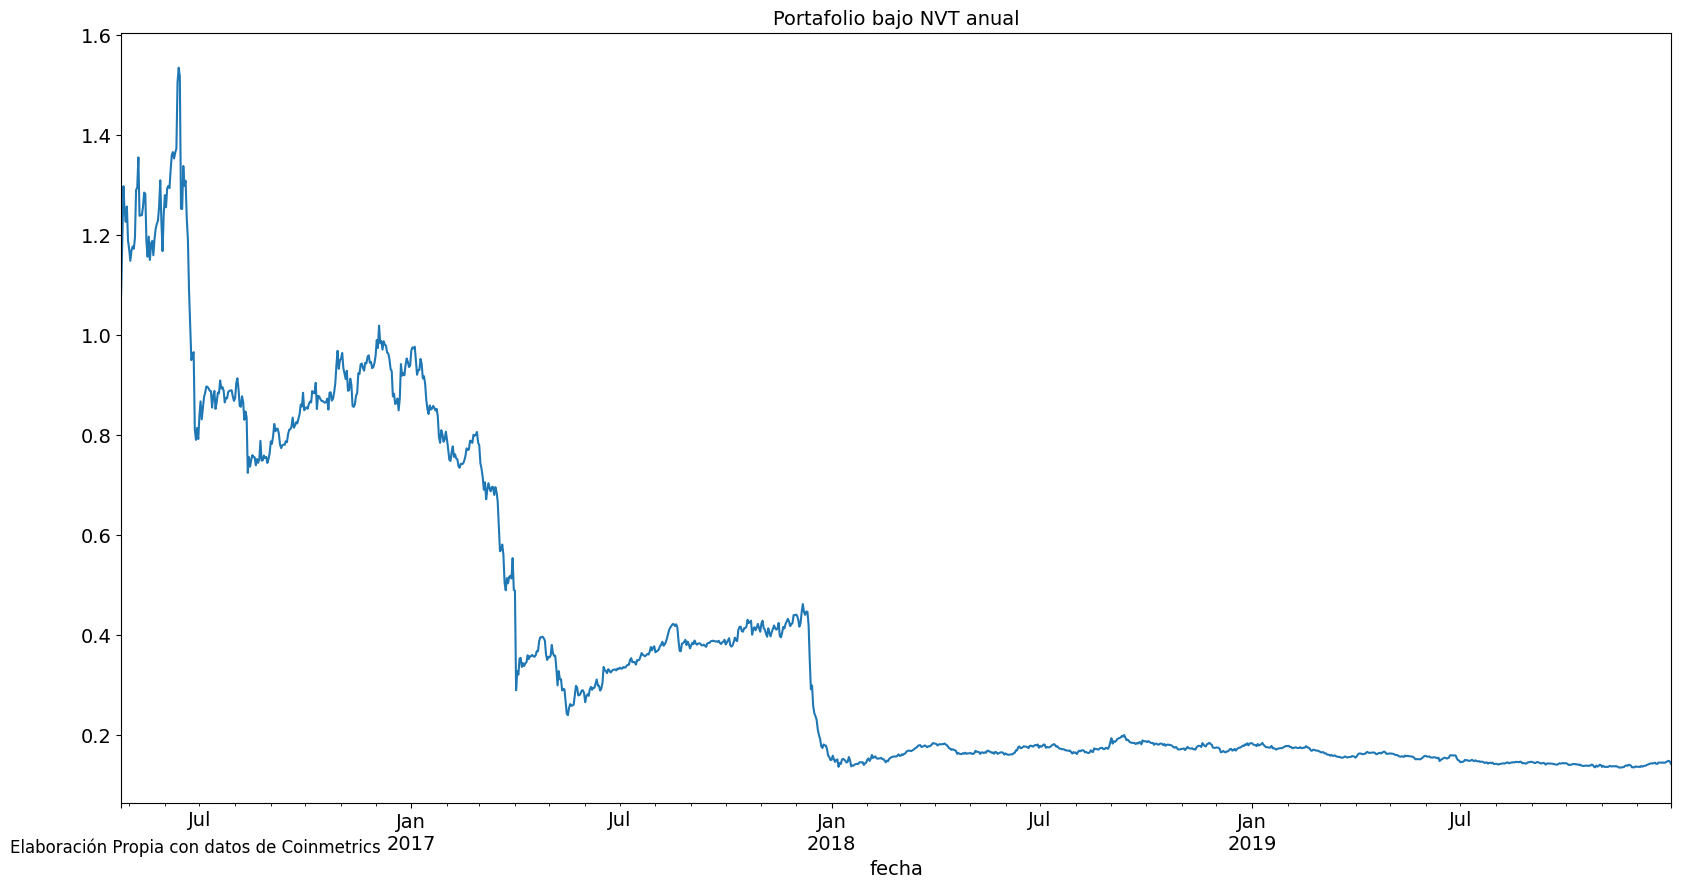

metricas estadisticas de los portafolios -0.3855477124893947 0.5149800374460878 -0.7486653548774828 -3.440526195387284


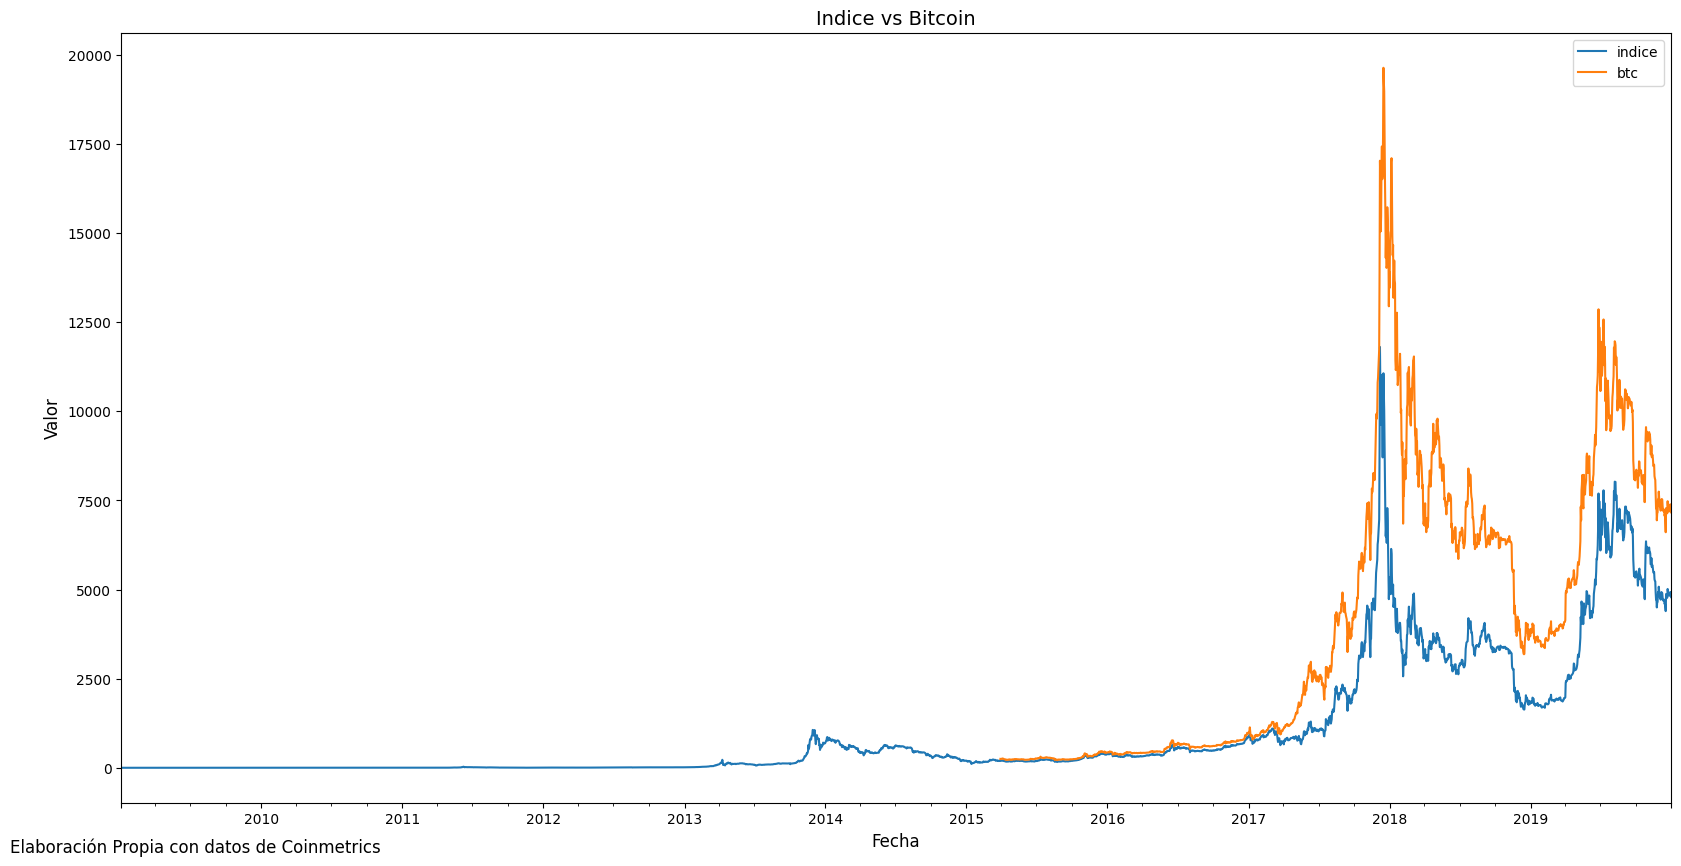

0.7605666080780433 0.8613442466623031 0.8829995800462223
..............................
 modelo de regresion CAPM 

<bound method Summary.as_latex of <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                  rp_rf   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3120
Date:                Mon, 24 Jul 2023   Prob (F-statistic):              0.577
Time:                        07:20:31   Log-Likelihood:                 2074.9
No. Observations:                 929   AIC:                            -4146.
Df Residuals:                     927   BIC:                            -4136.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
            

<ipython-input-19-56d0e3c8775b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  famma_week_1.replace(np.inf,np.nan,inplace=True)


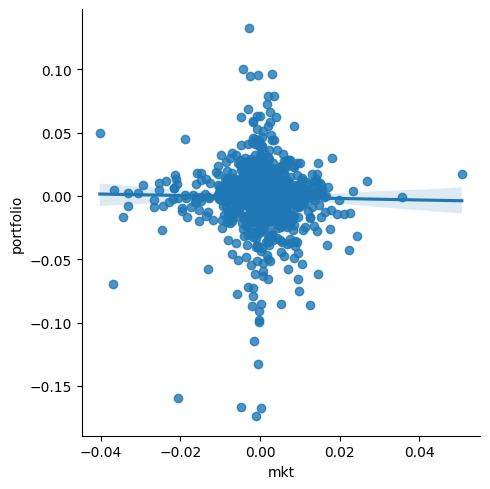

In [34]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore as score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from datetime import datetime, timedelta

main()

In [ ]:


def find_data():
    prices_bef_covi = pd.read_csv('precios_nvt_final.csv', index_col='time', parse_dates=True)
    return prices_bef_covi

def find_data2():
    nvt_bef_cov = pd.read_csv('nvt_valores_final.csv', index_col='time', parse_dates=True)
    return nvt_bef_cov


def main():
    #ingreso parametros
    nvt_period = input('Ingrese el nvt period ')
    nvt_period = int(nvt_period)
    reb= input('Ingrese el periodo de rebalanceo')
    reb = int(reb)
    nvt_bef_cov = find_data2()
    nvt_pct=nvt_bef_cov.rolling(window=nvt_period,axis=0).mean()
    ranks(nvt_pct, reb)


def ranks(nvt_pct, reb):
    #rankeo
    ranks=pd.DataFrame(columns=nvt_pct.columns,index=nvt_pct.index)

    for i in range(len(nvt_pct)):
      if i%reb==0:
          ranks.iloc[i]=nvt_pct.iloc[i].rank(axis=0,method='first',ascending=False)
    ranks=ranks.shift(periods=1,axis=0)
    ranks.ffill(inplace=True,limit=reb)

   # compro NVT chico, vendo NVT grande
    n_long=np.floor(ranks.count(axis=1)/5)
    n_short=np.floor(ranks.count(axis=1)/5)
    n_coins=ranks.count(axis=1)-n_long+1

    for col in ranks.columns:
        ranks.loc[ranks[col]<=n_long,col]=-1
        ranks.loc[ranks[col]>=n_coins,col]=1
        ranks.loc[(ranks[col]<n_coins) & (ranks[col]>n_long),col]=None

    prices_bef_covi = find_data()

    WandL(ranks,prices_bef_covi,n_long, n_short)

    Time(ranks,prices_bef_covi,n_long, n_short)

# Graficas

In [32]:
from operator import mul
def WandL(rank,prices_bef_covi,n_long, n_short):
  winners=rank.replace(-1.0,np.nan)
  lossers=rank.replace(1.0,np.nan)

  win_port=(prices_bef_covi.pct_change())*winners
  los_port=(prices_bef_covi.pct_change())*lossers.replace(-1.0,1.0)

  win_port['ret']=win_port.sum(axis=1,skipna=True)/n_long
  los_port['ret']=los_port.sum(axis=1,skipna=True)/n_short

  win_port['Portfolio Value W']=((win_port['ret'] +1).cumprod())
  los_port['Portfolio Value L']=((los_port['ret'] +1).cumprod())

  win_port['Portfolio Value W'].plot()
  los_port['Portfolio Value L'].plot()
  plt.legend()
  dif=win_port['ret']-los_port['ret']
  dif.mean(),win_port['ret'].mean(),los_port['ret'].mean()
  t_stat(win_port['ret'],los_port['ret'])


def t_stat(x,y):
    meanx=x.mean()
    varx=x.std()**2
    meany=y.mean()
    vary=y.std()**2
    nx=x.count()
    ny=y.count()
    t=(meanx-meany)/np.sqrt(varx/nx+vary/ny)
    return t

def Time(rank,prices_bef_covi,n_long, n_short):
  %matplotlib inline
  mult_df=(prices_bef_covi.pct_change())*rank
  mult_df['Total Return']=(mult_df.sum(axis=1,skipna=True))/(n_long+n_short)
  mult_df=mult_df['04-24-2016':]

  mult_df['Portfolio Value']=((mult_df['Total Return'] +1).cumprod())
  mult_df1=mult_df.dropna(how="all")
  fecha= mult_df1.index.values[0]




  plt.figure(figsize=(20,10))
  mult_df['Portfolio Value'].plot(kind='line',fontsize=14)
  plt.title('Portafolio bajo NVT anual',fontsize=14)
  plt.xlabel('fecha',fontsize=14)
  plt.annotate('Elaboración Propia con datos de Coinmetrics', (0,0), (-80,-25), fontsize=12,
              xycoords='axes fraction', textcoords='offset points', va='top')
  plt.show()
  #metricas estadisticas de los portafolios

  sharpe_mean=mult_df['Total Return'].mean()*365
  sharpe_std=mult_df['Total Return'].std()*np.sqrt(365)
  sharpe=sharpe_mean/sharpe_std
  skew=mult_df['Total Return'].skew()

  print('metricas estadisticas de los portafolios', sharpe_mean,sharpe_std,sharpe,skew)

  index_df = mainmrkt()
  fammaport(mult_df,index_df,fecha)

# MRKT CAP INDEX

In [ ]:
def find_data3():
    index_df= pd.read_csv('crypto_index.csv', index_col='time', parse_dates=True)
    return index_df


def mainmrkt():
  index_df = find_data3()
  prices_bef_covi = find_data()
  index_df['indice'].plot(figsize=(20,10))
  prices_bef_covi['btc'].plot()

  plt.title('Indice vs Bitcoin',fontsize=14)
  plt.xlabel('Fecha',fontsize=12)
  plt.ylabel('Valor',fontsize=12)
  plt.legend()
  plt.annotate('Elaboración Propia con datos de Coinmetrics', (0,0), (-80,-25), fontsize=12,
              xycoords='axes fraction', textcoords='offset points', va='top')
  plt.show()

#comparaciones del indice del mercado ??
  index_er=index_df['08-02-2014':]['indice'].pct_change().mean()*365
  index_vol=index_df['08-02-2014':]['indice'].pct_change().std()*np.sqrt(365)
  index_sharpe=index_er/index_vol
  index_ret=index_df['indice'].pct_change()
  print(index_er,index_vol ,index_sharpe)

  return index_df

# Regresion

In [ ]:

def find_data4():
    famma=pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV',index_col='date',parse_dates=True)
    return famma

def fammaport(mult_df,index_df,fecha):
  famma = find_data4()
  famma_week=famma.copy()/100
  famma_week['portfolio']=mult_df['Portfolio Value'].pct_change()
  famma_week['crypto_mkt']=index_df['indice'].pct_change()
  #cambiar las fechas en cada portfolio ejemplo: 2016-04-23
  famma_week_1=famma_week[fecha:'2019-12-31']
  famma_week_1.replace(np.inf,np.nan,inplace=True)
  famma_week_1=famma_week_1.fillna(0)
  famma_week_1['rp_rf']=famma_week_1['portfolio']-famma_week_1['RF']
  famma_week_1.rename(columns={'Mkt-RF':'mkt_rf'},inplace=True)
  famma_week_1['mkt']=famma_week_1['mkt_rf']+famma_week_1['RF']
  famma_week_1['ci_rf']=famma_week_1['crypto_mkt']-famma_week['RF']

  regrCAPM(famma_week_1)
  regrindp(famma_week_1)
  regr3f(famma_week_1)
  regr5f(famma_week_1)
  regr6f(famma_week_1)
  sns.lmplot(data=famma_week_1,x='mkt',y='portfolio')

#regresion CAPM
def regrCAPM(famma_week_1):
  model_week= smf.ols('rp_rf ~ mkt_rf ', data=famma_week_1)
  results_week=model_week.fit(cov_type='HC3')
  print('..............................\n modelo de regresion CAPM \n')
  print(results_week.summary().as_latex)

#regresion vs indic propio
def regrindp(famma_week_1):
  model_week= smf.ols('rp_rf ~ ci_rf ', data=famma_week_1)
  results_week=model_week.fit(cov_type='HC3')
  print('..............................\n modelo de regresion vs indic propio\n')
  print(results_week.summary().as_latex)

# regresion 3 factores
def regr3f(famma_week_1):
  model_week= smf.ols('rp_rf ~ mkt_rf + SMB + HML', data=famma_week_1)
  results_week=model_week.fit(cov_type='HC3')
  print('..............................\n modelo de 3 factores sin tasa libre de riesgo\n')
  print(results_week.summary().as_latex)

#regresion 5 factores
def regr5f(famma_week_1):
  model_week= smf.ols('rp_rf ~ mkt_rf + SMB + HML + RMW + CMA', data=famma_week_1)
  results_week=model_week.fit(cov_type='HC3')
  print('..............................\n modelo de 5 factores sin tasa libre de riesgo\n')
  print(results_week.summary().as_latex)
#modelo de 6 factores sin tasa libre de riesgo
def regr6f(famma_week_1):
  model_week= smf.ols('portfolio ~ crypto_mkt+ mkt + SMB + HML + RMW + CMA ', data=famma_week_1)
  results_week=model_week.fit(cov_type='HC3')
  print('..............................\n modelo de 6 factores sin tasa libre de riesgo\n')
  print(results_week.summary().as_latex)